# Forecast PES10 Region Production Notebook
Author: George Panagiotou

In [5]:
import pandas as pd
import numpy as np
from comp_utils import *
import os
from sklearn.linear_model import QuantileRegressor
from concurrent.futures import ThreadPoolExecutor, as_completed
import joblib
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, mean_pinball_loss
from concurrent.futures import ProcessPoolExecutor
from sklearn.utils import check_array

## Load Train data:

In [2]:
train_table = pd.read_hdf('data/reference_time_06/SolarTrainTable.h5', 'df')

print('Train features before removing columns:', train_table.shape)

train_times = train_table['valid_time']
train_target_variable = train_table['Solar_MWh_credit'] / train_table['Solar_installedcapacity_mwp']
train_solar_capacity = train_table['Solar_installedcapacity_mwp']

train_table = train_table.drop(['Solar_MWh_credit','Solar_installedcapacity_mwp','Solar_capacity_mwp'], axis=1)
print('Train features after removing columns:', train_table.shape)

Train features before removing columns: (56385, 72)
Train features after removing columns: (56385, 69)


## Load Test data:

In [3]:
test_table = pd.read_hdf('data/reference_time_06/SolarTestTable.h5', 'df')

print('Test features before removing columns:', test_table.shape)

test_times = test_table['valid_time']
test_target_variable= test_table['Solar_MWh_credit'] / test_table['Solar_installedcapacity_mwp']
test_solar_capacity = test_table['Solar_installedcapacity_mwp']

test_table = test_table.drop(['Solar_MWh_credit','Solar_installedcapacity_mwp','Solar_capacity_mwp'], axis=1)
print('Test features after removing columns:', test_table.shape)

Test features before removing columns: (4318, 72)
Test features after removing columns: (4318, 69)


## Transforming time into cyclic features:

In [4]:
train_table = add_cyclic_features(train_table)
train_table = train_table.drop(columns=["valid_time"])
print('Train features after adding cyclic times and removing valid_time:', train_table.shape)

test_table = add_cyclic_features(test_table)
test_table = test_table.drop(columns=["valid_time"])
print('Test features after adding cyclic times and removing valid_time:', test_table.shape)

Train features after adding cyclic times and removing valid_time: (56385, 77)
Test features after adding cyclic times and removing valid_time: (4318, 77)


## Linear Quantile Regressor (Training)
!!! DO NOT RUN !!!

In [5]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

def train_and_save_model(quantile, train_table, train_target_variable):
    print(f"Training model for quantile {quantile}...")

    # Ensure data is writeable
    train_table = check_array(train_table, copy=True, dtype=np.float64)
    train_target_variable = check_array(train_target_variable, ensure_2d=False, copy=True, dtype=np.float64)

    # Fixed alpha value
    alpha = 0.01

    model = QuantileRegressor(quantile=quantile, alpha=alpha)
    model.fit(train_table, train_target_variable)

    # Save the model
    model_path = f'models/LinearQ/LQR_Solar_BEST_q{int(quantile * 100)}.joblib'
    joblib.dump(model, model_path)

    print(f"Finished training model for quantile {quantile} with alpha {alpha}.")

# Using ProcessPoolExecutor to parallelize the training
with ProcessPoolExecutor(max_workers=len(quantiles)) as executor:
    futures = {executor.submit(train_and_save_model, quantile, train_table, train_target_variable): quantile for quantile in quantiles}
    for future in as_completed(futures):
        future.result()




Training model for quantile 0.1...
Training model for quantile 0.2...
Training model for quantile 0.3...
Training model for quantile 0.4...
Training model for quantile 0.5...
Training model for quantile 0.6...
Training model for quantile 0.7...
Training model for quantile 0.8...
Training model for quantile 0.9...
Finished training model for quantile 0.9 with alpha 0.01.
Finished training model for quantile 0.1 with alpha 0.01.
Finished training model for quantile 0.8 with alpha 0.01.
Finished training model for quantile 0.7 with alpha 0.01.
Finished training model for quantile 0.2 with alpha 0.01.
Finished training model for quantile 0.5 with alpha 0.01.
Finished training model for quantile 0.6 with alpha 0.01.
Finished training model for quantile 0.4 with alpha 0.01.
Finished training model for quantile 0.3 with alpha 0.01.


## Train set:

We are going to make predictions of the training set. Then, we will use the predictions as the new training set for the ensemble method that is going to combine both solar and wind production and predict the hybrid production of both. 

In [6]:
quantile_predictions = {}
quantile_predictions['Solar_MWh_credit'] = train_target_variable * train_solar_capacity

# Define the quantiles
quantiles = range(10, 100, 10)

# Load models and predict
for qu in quantiles:
    quantile = qu / 100.0
    model_path = f'models/LinearQ/LQR_Solar_BEST_q{int(quantile * 100)}.joblib'
    model = joblib.load(model_path)
    quantile_predictions[f'q{qu}'] = model.predict(train_table) * train_solar_capacity

# Create DataFrame from predictions
quantile_predictions_df = pd.DataFrame(quantile_predictions)

# Ensure predictions are non-negative
quantile_columns = [col for col in quantile_predictions_df.columns if col.startswith('q')]
quantile_predictions_df[quantile_columns] = quantile_predictions_df[quantile_columns].map(lambda x: max(x, 0))
quantile_predictions_df = sort_quantiles(quantile_predictions_df, quantile_columns)

print('Training Loss (Quantile):',pinball_score(quantile_predictions_df, target_col='Solar_MWh_credit'))

quantile_predictions_df['time'] = train_times  
csv_file_path = 'data/LinearQ/Solar_train_quantiles.csv'
quantile_predictions_df.to_csv(csv_file_path, index=False)

/home/thesis/George/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but QuantileRegressor was fitted without feature names
  warnings.warn(
/home/thesis/George/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but QuantileRegressor was fitted without feature names
  warnings.warn(
/home/thesis/George/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but QuantileRegressor was fitted without feature names
  warnings.warn(
/home/thesis/George/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but QuantileRegressor was fitted without feature names
  warnings.warn(
/home/thesis/George/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but QuantileRegressor was fitted without feature names
  warnings.warn(
/home/thesis/George/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X

Training Loss (Quantile): 11.754807977845127


## Test set

We will use the predictions as the new test set for the ensemble method that is going to combine both solar and wind production and predict the hybrid production of both. 

In [7]:
quantile_predictions = {}
quantile_predictions['Solar_MWh_credit'] = test_target_variable * test_solar_capacity

# Define the quantiles
quantiles = range(10, 100, 10)

# Load models and predict
for qu in quantiles:
    quantile = qu / 100.0  # Convert integer to fraction (e.g., 10 to 0.1)
    model_path = f'models/LinearQ/LQR_Solar_BEST_q{int(quantile * 100)}.joblib'
    model = joblib.load(model_path)
    quantile_predictions[f'q{qu}'] = model.predict(test_table) * test_solar_capacity

# Create DataFrame from predictions
quantile_predictions_df = pd.DataFrame(quantile_predictions)

# Ensure predictions are non-negative
quantile_columns = [col for col in quantile_predictions_df.columns if col.startswith('q')]
quantile_predictions_df[quantile_columns] = quantile_predictions_df[quantile_columns].map(lambda x: max(x, 0))
quantile_predictions_df = sort_quantiles(quantile_predictions_df, quantile_columns)

print('Test Loss (Quantile):',pinball_score(quantile_predictions_df, target_col='Solar_MWh_credit'))

quantile_predictions_df['time'] = test_times  
csv_file_path = 'data/LinearQ/Solar_test_quantiles.csv'
quantile_predictions_df.to_csv(csv_file_path, index=False)

/home/thesis/George/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but QuantileRegressor was fitted without feature names
  warnings.warn(
/home/thesis/George/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but QuantileRegressor was fitted without feature names
  warnings.warn(
/home/thesis/George/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but QuantileRegressor was fitted without feature names
  warnings.warn(
/home/thesis/George/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but QuantileRegressor was fitted without feature names
  warnings.warn(
/home/thesis/George/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but QuantileRegressor was fitted without feature names
  warnings.warn(
/home/thesis/George/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X

Test Loss (Quantile): 12.571303869029506


## Plot Quantiles ( Probabilistic Forecasting) :

In [8]:
save_path = "plots/LinearQ/Solar_LQR.html"
graph_title = "PV: Forecast (LinearQRegressor)"
quantile_predictions_df['time'] = test_times  
plot_quantiles_target_and_average_loss_interactive(quantile_predictions_df, 'Solar_MWh_credit', test_times, save_path, title=graph_title)

## Plot Statistics of Quantiles

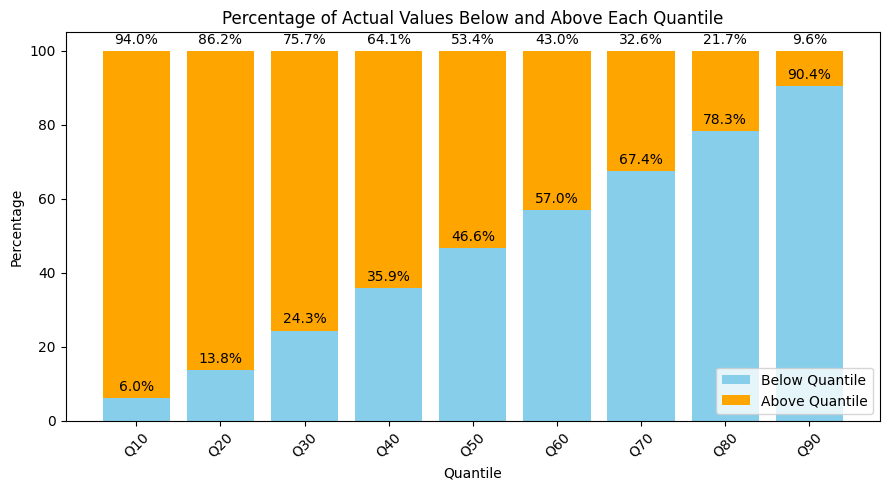

In [9]:
quantile_stats(quantile_predictions_df, 'Solar_MWh_credit')

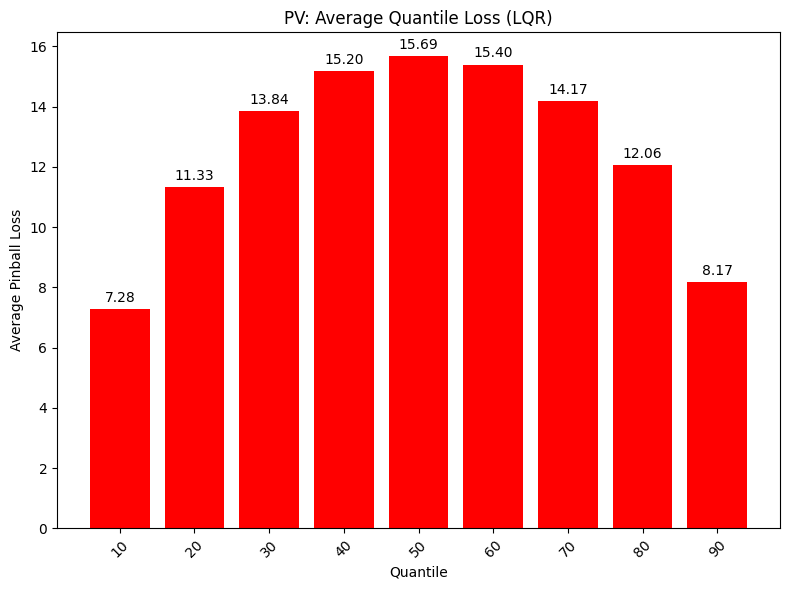

In [11]:
calculate_and_plot_average_quantile_loss(quantile_predictions_df, 'Solar_MWh_credit', "PV: Average Quantile Loss (LQR)")